Source: https://medium.com/analytics-vidhya/an-introduction-to-multi-label-text-classification-b1bcb7c7364c

Dataset: https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles?select=train.csv

In [ ]:
!pip install scikit-multilearn

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain, LabelPowerset
import pandas as pd

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d blessondensil294/topic-modeling-for-research-articles -p /content
!unzip -q topic-modeling-for-research-articles.zip -d /content/dataset

Dataset URL: https://www.kaggle.com/datasets/blessondensil294/topic-modeling-for-research-articles
License(s): DbCL-1.0


In [ ]:
train_data = pd.read_csv('/content/dataset/train.csv')
train_data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
labels_count = train_data.iloc[:, 3:].sum(axis=0)
labels_per_sample = train_data.iloc[:, 3:].sum(axis=1)
without_label_count = 0
for lbl_count in labels_per_sample:
    if lbl_count == 0:
        without_label_count += 1

print("Total number of articles = ",len(train_data))
print("Total number of articles without label = ", without_label_count)
print("Total labels = ", labels_count.sum())

Total number of articles =  20972
Total number of articles without label =  0
Total labels =  26267


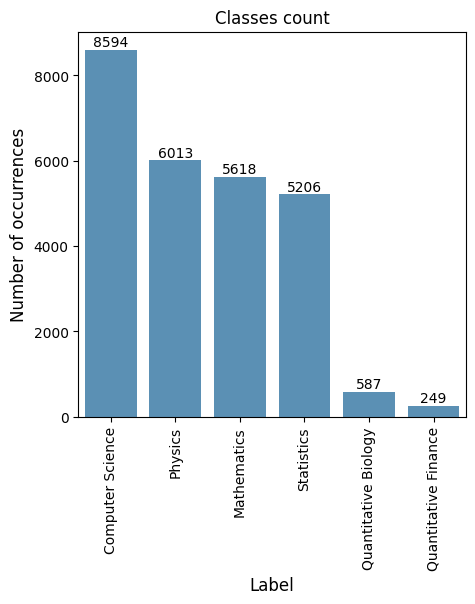

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.barplot(x=labels_count.index, y=labels_count.values, alpha=0.8)
plt.title("Classes count")
plt.xlabel("Label", fontsize=12)
plt.ylabel("Number of occurrences", fontsize=12)
plt.xticks(rotation=90)
rects, labels = ax.patches, labels_count.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [ ]:
train_data['Text'] = train_data['TITLE'] + ' ' + train_data['ABSTRACT']
train_data = train_data.drop(columns=['ID', 'TITLE', 'ABSTRACT'])
train_data.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,Text
0,1,0,0,0,0,0,Reconstructing Subject-Specific Effect Maps ...
1,1,0,0,0,0,0,Rotation Invariance Neural Network Rotation ...
2,0,0,1,0,0,0,Spherical polyharmonics and Poisson kernels fo...
3,0,0,1,0,0,0,A finite element approximation for the stochas...
4,1,0,0,1,0,0,Comparative study of Discrete Wavelet Transfor...


In [ ]:
# Text preprocessing
#Remove Stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    without_stopwords_text = [w for w in text.split() if w not in stop_words]
    return ' '.join(without_stopwords_text)

#Clean Text
def clean_text(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", " ", text)
    return ' '.join(text.split())

#Stemming
stemmer = SnowballStemmer('english')
def stemming(text):
    stemText = ""
    for word in text.split():
        stemWord = stemmer.stem(word)
        stemText += stemWord
        stemText += " "
    return stemText.strip()

train_data['Text'] = train_data['Text'].apply(remove_stopwords)
train_data['Text'] = train_data['Text'].apply(clean_text)
train_data['Text'] = train_data['Text'].apply(stemming)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
X = train_data['Text']
y = train_data.drop(['Text'], axis=1)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [ ]:
tfidfvector = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidfvector.fit_transform(X_train)
X_val_tfidf = tfidfvector.transform(X_val)

#Logistic Regression

In [ ]:
cls1 = BinaryRelevance(LogisticRegression(solver='sag'))
cls1.fit(X_train_tfidf, y_train)
pred1 = cls1.predict(X_val_tfidf)

print('Accuracy = ', accuracy_score(y_val, pred1))
print('F1 score = ',f1_score(y_val, pred1, average="micro"))
print('Hamming Loss = ', hamming_loss(y_val, pred1))

Accuracy =  0.6476758045292015
F1 score =  0.802777218756289
Hamming Loss =  0.07787048073102901


In [ ]:
cls2 = ClassifierChain(LogisticRegression(solver='sag'))
cls2.fit(X_train_tfidf, y_train)
pred2 = cls2.predict(X_val_tfidf)

print('Accuracy = ', accuracy_score(y_val, pred2))
print('F1 score = ',f1_score(y_val, pred2, average="micro"))
print('Hamming Loss = ', hamming_loss(y_val, pred2))

Accuracy =  0.6769964243146603
F1 score =  0.8047722342733189
Hamming Loss =  0.07866507747318235


In [ ]:
cls3 = LabelPowerset(LogisticRegression(solver='sag'))
cls3.fit(X_train_tfidf, y_train)
pred3 = cls3.predict(X_val_tfidf)

print('Accuracy = ', accuracy_score(y_val, pred3))
print('F1 score = ',f1_score(y_val, pred3, average="micro"))
print('Hamming Loss = ', hamming_loss(y_val, pred3))

Accuracy =  0.6865315852205006
F1 score =  0.8093446842209463
Hamming Loss =  0.07651966626936829


# Neural Networks

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Convert target labels to NumPy arrays
import numpy as np
y_train = np.array(y_train)
y_test = np.array(y_val)

In [ ]:
# Define the MLP model
model = Sequential()
model.add(Dense(1024, input_shape=(X_train_tfidf.shape[1], ), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.summary()

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │       5,121,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           6,150 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,127,174 (19.56 MB)

 Trainable params: 5,127,174 (19.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()

In [ ]:
# Train the model
history = model.fit(X_train_tfidf_dense, y_train, validation_data=(X_val_tfidf_dense, y_val), callbacks=[monitor], epochs=30, batch_size=64)

Epoch 1/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6333 - loss: 0.3632 - val_accuracy: 0.7607 - val_loss: 0.1873
Epoch 2/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7932 - loss: 0.1493 - val_accuracy: 0.7626 - val_loss: 0.1824
Epoch 3/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8179 - loss: 0.1165 - val_accuracy: 0.7540 - val_loss: 0.1924
Epoch 4/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8381 - loss: 0.0920 - val_accuracy: 0.7497 - val_loss: 0.2058
Epoch 5/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8483 - loss: 0.0718 - val_accuracy: 0.7509 - val_loss: 0.2233
Epoch 6/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8641 - loss: 0.0530 - val_accuracy: 0.7428 - val_loss: 0.2445
Epoch 7/30
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8700 - loss: 0.0377 - val_accuracy: 0.7492 - val_loss: 0.2669
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Predictions on the validation set
y_pred = model.predict(X_val_tfidf_dense)

# Convert predicted probabilities to binary labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model using appropriate multi-label classification metrics
accuracy = accuracy_score(y_val, y_pred_binary)
hamming_loss_value = hamming_loss(y_val, y_pred_binary)
f1_micro = f1_score(y_val, y_pred_binary, average='micro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Hamming Loss: {hamming_loss_value:.2f}")
print(f"F1 Micro: {f1_micro:.2f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy: 0.66
Hamming Loss: 0.08
F1 Micro: 0.82
